In [1]:
import numpy as np
import pandas as pd
import math
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
#import keras.backend as K
from tqdm import trange, tqdm
import pickle
from keras.utils import metrics_utils, data_utils, losses_utils
from keras.metrics import Metric

from skater.core.explanations import Interpretation
from skater.model import InMemoryModel
from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score

In [2]:
tf.compat.v1.set_random_seed(42)

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### Import du modèle LSTM

In [3]:
class F1Score(Metric):
    r"""Computes F-1 Score.
    This is the harmonic mean of precision and recall.
    Its output range is `[0, 1]`. It works for both multi-class
    and multi-label classification.
    It is defined as:
    ```python
    f1_score = 2 * (precision * recall) / (precision + recall)
    ```
    Args:
        average: Type of averaging to be performed on data.
            Acceptable values are `None`, `"micro"`, `"macro"`
            and `"weighted"`. Default value is `None`.
            If `None`, no averaging is performed and `result()` will return
            the score for each class.
            If `"micro"`, compute metrics globally by counting the total
            true positives, false negatives and false positives.
            If `"macro"`, compute metrics for each label,
            and return their unweighted mean.
            This does not take label imbalance into account.
            If `"weighted"`, compute metrics for each label,
            and return their average weighted by support
            (the number of true instances for each label).
            This alters `"macro"` to account for label imbalance.
            It can result in an score that is not between precision and recall.
        threshold: Elements of `y_pred` greater than `threshold` are
            converted to be 1, and the rest 0. If `threshold` is
            `None`, the argmax of `y_pred` is converted to 1, and the rest to 0.
        name: Optional. String name of the metric instance.
        dtype: Optional. Data type of the metric result.
    Returns:
        F-1 Score: float.
    Example:
    >>> metric = tf.keras.metrics.F1Score(threshold=0.5)
    >>> y_true = np.array([[1, 1, 1],
    ...                    [1, 0, 0],
    ...                    [1, 1, 0]], np.int32)
    >>> y_pred = np.array([[0.2, 0.6, 0.7],
    ...                    [0.2, 0.6, 0.6],
    ...                    [0.6, 0.8, 0.0]], np.float32)
    >>> metric.update_state(y_true, y_pred)
    >>> result = metric.result()
    >>> result.numpy()
    array([0.5      , 0.8      , 0.6666667], dtype=float32)
    """
    
    def __init__(self,
               thresholds=None,
               top_k=None,
               class_id=None,
               name=None,
               dtype=None,
               **kwargs):
        super().__init__(name=name, dtype=dtype, **kwargs)
        self.init_thresholds = thresholds
        self.top_k = top_k
        self.class_id = class_id

        default_threshold = 0.5 if top_k is None else metrics_utils.NEG_INF
        self.thresholds = metrics_utils.parse_init_thresholds(
            thresholds, default_threshold=default_threshold)
        self._thresholds_distributed_evenly = (
            metrics_utils.is_evenly_distributed_thresholds(self.thresholds))
        self.true_positives = self.add_weight(
            'true_positives',
            shape=(len(self.thresholds),),
            initializer=tf.compat.v1.zeros_initializer)
        self.false_positives = self.add_weight(
            'false_positives',
            shape=(len(self.thresholds),),
            initializer=tf.compat.v1.zeros_initializer)
        self.false_negatives = self.add_weight(
            'false_negatives',
            shape=(len(self.thresholds),),
            initializer=tf.compat.v1.zeros_initializer)

    def update_state(self, y_true, y_pred, sample_weight=None):
        """Accumulates true positive and false positive statistics.
        Args:
          y_true: The ground truth values, with the same dimensions as `y_pred`.
            Will be cast to `bool`.
          y_pred: The predicted values. Each element must be in the range `[0, 1]`.
          sample_weight: Optional weighting of each example. Defaults to 1. Can be a
            `Tensor` whose rank is either 0, or the same rank as `y_true`, and must
            be broadcastable to `y_true`.
        Returns:
          Update op.
        """
        return metrics_utils.update_confusion_matrix_variables(
            {
                metrics_utils.ConfusionMatrix.TRUE_POSITIVES: self.true_positives,
                metrics_utils.ConfusionMatrix.FALSE_POSITIVES: self.false_positives,
                metrics_utils.ConfusionMatrix.FALSE_NEGATIVES: self.false_negatives
            },
            y_true,
            y_pred,
            thresholds=self.thresholds,
            thresholds_distributed_evenly=self._thresholds_distributed_evenly,
            top_k=self.top_k,
            class_id=self.class_id,
            sample_weight=sample_weight)

    def result(self):
        result = tf.math.divide_no_nan(2 * self.true_positives,
                                     2 * self.true_positives + self.false_positives + self.false_negatives)
        return result[0] if len(self.thresholds) == 1 else result

    def reset_state(self):
        num_thresholds = len(to_list(self.thresholds))
        K.batch_set_value([(v, np.zeros((num_thresholds,)))
                                 for v in (self.true_positives,
                                           self.false_positives, self.false_negatives)])

    def get_config(self):
        config = {
            'thresholds': self.init_thresholds,
            'top_k': self.top_k,
            'class_id': self.class_id
        }
        base_config = super(Metric, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [4]:
class WeightedCrossEntropy(tf.keras.losses.Loss):
    def __init__(
        self,
        pos_weight=1.0,
        axis=-1,
        reduction=losses_utils.ReductionV2.AUTO,
        name="weighted_binary_crossentropy"
    ):
        super().__init__(
            name=name,
            reduction=reduction
        )
        self.axis = axis
        self.pos_weight = pos_weight

    def call(self, y_true, y_pred):
        
        y_pred = tf.convert_to_tensor(y_pred)
        y_true = tf.cast(y_true, y_pred.dtype)
        pos_weight = tf.convert_to_tensor(self.pos_weight, dtype=y_pred.dtype)

        #epsilon_ = tf.convert_to_tensor(backend_config.epsilon(), dtype=y_pred.dtype)
        epsilon_ = backend_config.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon_, 1.0 - epsilon_)

        # Compute cross entropy from probabilities.
        bce = y_true * tf.math.log(y_pred) * pos_weight
        bce += (1 - y_true) * tf.math.log(1 - y_pred)

        return -tf.reduce_mean(bce, axis=self.axis)

    def get_config(self):
        config = {
            'pos_weight': self.pos_weight
        }
        base_config = super().get_config()
        return {**base_config, **config}

In [5]:
custom_objects = { "F1Score": F1Score, "WeightedCrossEntropy":WeightedCrossEntropy }
with tf.keras.utils.custom_object_scope(custom_objects):
    model = tf.keras.models.load_model('weather_models/albury_model1.h5')

with open('weather_models/albury_X_train1.pickle', 'rb') as handle:
    X_train = pickle.load(handle)
with open('weather_models/albury_y_train1.pickle', 'rb') as handle:
    y_train = pickle.load(handle)
with open('weather_models/albury_X_test1.pickle', 'rb') as handle:
    X_test = pickle.load(handle)
with open('weather_models/albury_y_test1.pickle', 'rb') as handle:
    y_test = pickle.load(handle)
with open('weather_models/scaler1.pickle', 'rb') as handle:
    scaler = pickle.load(handle)   
with open('weather_models/cols_to_scale1.pickle', 'rb') as handle:
    cols_to_scale = pickle.load(handle)

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 4, 13)]           0         
_________________________________________________________________
lstm1 (LSTM)                 (None, 4, 64)             19968     
_________________________________________________________________
lstm2 (LSTM)                 (None, 64)                33024     
_________________________________________________________________
lstm_final_dropout (Dropout) (None, 64)                0         
_________________________________________________________________
flatten_final (Flatten)      (None, 64)                0         
_________________________________________________________________
dense1 (Dense)               (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0     

### Transformation inverse des données pour améliorer la lisibilité des résultats

In [7]:
X_train[cols_to_scale] = scaler.inverse_transform(X_train[cols_to_scale])
X_test[cols_to_scale] = scaler.inverse_transform(X_test[cols_to_scale])

In [8]:
class TimeseriesGeneratorMultiOutput(data_utils.Sequence):
    """Utility class for generating batches of temporal data.
    Deprecated: `tf.keras.preprocessing.sequence.TimeseriesGenerator` does not
    operate on tensors and is not recommended for new code. Prefer using a
    `tf.data.Dataset` which provides a more efficient and flexible mechanism for
    batching, shuffling, and windowing input. See the
    [tf.data guide](https://www.tensorflow.org/guide/data) for more details.
    This class takes in a sequence of data-points gathered at
    equal intervals, along with time series parameters such as
    stride, length of history, etc., to produce batches for
    training/validation.
    Arguments:
        data: Indexable generator (such as list or Numpy array)
            containing consecutive data points (timesteps).
            The data should be at 2D, and axis 0 is expected
            to be the time dimension.
        targets: Targets corresponding to timesteps in `data`.
            It should have same length as `data`.
        length: Length of the output sequences (in number of timesteps).
        sampling_rate: Period between successive individual timesteps
            within sequences. For rate `r`, timesteps
            `data[i]`, `data[i-r]`, ... `data[i - length]`
            are used for create a sample sequence.
        stride: Period between successive output sequences.
            For stride `s`, consecutive output samples would
            be centered around `data[i]`, `data[i+s]`, `data[i+2*s]`, etc.
        start_index: Data points earlier than `start_index` will not be used
            in the output sequences. This is useful to reserve part of the
            data for test or validation.
        end_index: Data points later than `end_index` will not be used
            in the output sequences. This is useful to reserve part of the
            data for test or validation.
        shuffle: Whether to shuffle output samples,
            or instead draw them in chronological order.
        reverse: Boolean: if `true`, timesteps in each output sample will be
            in reverse chronological order.
        batch_size: Number of timeseries samples in each batch
            (except maybe the last one).
    Returns:
        A [Sequence](
        https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence)
        instance.
    Examples:
        ```python
        from keras.preprocessing.sequence import TimeseriesGenerator
        import numpy as np
        data = np.array([[i] for i in range(50)])
        targets = np.array([[i] for i in range(50)])
        data_gen = TimeseriesGenerator(data, targets,
                                       length=10, sampling_rate=2,
                                       batch_size=2)
        assert len(data_gen) == 20
        batch_0 = data_gen[0]
        x, y = batch_0
        assert np.array_equal(x,
                              np.array([[[0], [2], [4], [6], [8]],
                                        [[1], [3], [5], [7], [9]]]))
        assert np.array_equal(y,
                              np.array([[10], [11]]))
        ```
    """

    def __init__(
        self,
        data,
        targets,
        length,
        sampling_rate=1,
        stride=1,
        start_index=0,
        end_index=None,
        shuffle=False,
        reverse=False,
        batch_size=128,
        output_names=None
    ):

        if len(data) != len(targets):
            raise ValueError(
                "Data and targets have to be"
                + f" of same length. Data length is {len(data)}"
                + f" while target length is {len(targets)}"
            )
            
        st = np.shape(targets)
        if output_names is not None and len(output_names) != st[1]:
            raise ValueError(
                "Multi-output targets require a valid output_names"
            )
                
        self.data = np.asarray(data)
        self.targets = np.asarray(targets)
        self.length = length
        self.sampling_rate = sampling_rate
        self.stride = stride
        self.start_index = start_index + length
        if end_index is None:
            end_index = len(data) - 1
        self.end_index = end_index
        self.shuffle = shuffle
        self.reverse = reverse
        self.batch_size = batch_size
        self.output_names = output_names
        self.true_ratio = np.mean(targets)

        if self.start_index > self.end_index:
            raise ValueError(
                "`start_index+length=%i > end_index=%i` "
                "is disallowed, as no part of the sequence "
                "would be left to be used as current step."
                % (self.start_index, self.end_index)
            )
            
        
        batch_stride = self.batch_size * self.stride
        self._len = (self.end_index - self.start_index + batch_stride) // batch_stride
        self.start_indexes = np.arange(self.start_index, self.start_index + batch_stride * self._len, batch_stride)
        if self.shuffle:
            self.start_indexes = np.random.permutation(self.start_indexes)

    def __len__(self):
        return self._len

    def __getitem__(self, index):
        i = self.start_indexes[index]
        rows = np.arange(
            i,
            min(i + self.batch_size * self.stride, self.end_index + 1),
            self.stride,
        )

        samples = np.array(
            [
                self.data[row - self.length : row : self.sampling_rate]
                for row in rows
            ]
        )
        
        if self.output_names is not None:
            atargets = np.array([self.targets[row] for row in rows])
            atargets = np.swapaxes(atargets, 1, 0)
            
            targets = {}
            for i, n in enumerate(self.output_names):
                targets[n] = atargets[i]
        else:
            targets = np.array([self.targets[row] for row in rows])

        if self.reverse:
            return samples[:, ::-1, ...], targets
        return samples, targets
    
    def on_epoch_end(self):
        super().on_epoch_end()        
        if self.shuffle:
            self.start_indexes = np.random.permutation(self.start_indexes)

    def get_config(self):
        """Returns the TimeseriesGenerator configuration as Python dictionary.
        Returns:
            A Python dictionary with the TimeseriesGenerator configuration.
        """
        data = self.data
        if type(self.data).__module__ == np.__name__:
            data = self.data.tolist()
        try:
            json_data = json.dumps(data)
        except TypeError as e:
            raise TypeError("Data not JSON Serializable:", data) from e

        targets = self.targets
        if type(self.targets).__module__ == np.__name__:
            targets = self.targets.tolist()
        try:
            json_targets = json.dumps(targets)
        except TypeError as e:
            raise TypeError("Targets not JSON Serializable:", targets) from e

        return {
            "data": json_data,
            "targets": json_targets,
            "length": self.length,
            "sampling_rate": self.sampling_rate,
            "stride": self.stride,
            "start_index": self.start_index,
            "end_index": self.end_index,
            "shuffle": self.shuffle,
            "reverse": self.reverse,
            "batch_size": self.batch_size,
            "output_names": self.output_names,
        }

    def to_json(self, **kwargs):
        """Returns a JSON string containing the generator's configuration.
        Args:
            **kwargs: Additional keyword arguments to be passed
                to `json.dumps()`.
        Returns:
            A JSON string containing the tokenizer configuration.
        """
        config = self.get_config()
        timeseries_generator_config = {
            "class_name": self.__class__.__name__,
            "config": config,
        }
        return json.dumps(timeseries_generator_config, **kwargs)

In [9]:
def unroll_time_data(X_train, y_train, window_size):
    feature_names = []
    for i in range(window_size):
        for f in X_train.columns:
            feature_names.append(f + '_day' + str(window_size - i))

    train_generator = TimeseriesGeneratorMultiOutput(X_train, y_train, length=window_size, stride=1,
                                                         batch_size=1, shuffle=False)

    X_data = []
    y_data = []
    for X, y in train_generator:
        X_data.append(np.reshape(X, (-1,)))
        y_data.append(y.item())

    X_unrolled = pd.DataFrame(data=X_data, columns=feature_names)
    y_unrolled = pd.Series(data=y_data)
    
    return (X_unrolled, y_unrolled)

In [10]:
# Unroll data.

window_size = 4
feature_count = len(X_test.columns)

X_unrolled, y_unrolled = unroll_time_data(X_train, y_train, window_size)
X_test_unrolled, y_test_unrolled = unroll_time_data(X_test, y_test, window_size)

<h2>Interprétation globale avec Skater</h2>

In [12]:
def predict_raintomorrow(x):
    x = x.copy()
    for i in range(window_size):
        day_cols_to_scale = [str(col) + '_day' + str(window_size - i) for col in cols_to_scale]
        col_name_mapper = {str(col) + '_day' + str(window_size - i):col for col in cols_to_scale}
        xp = x.loc[:, day_cols_to_scale].rename(columns=col_name_mapper)
        xp = scaler.transform(xp)
        x.loc[:, day_cols_to_scale] = xp
    
    xd = np.reshape(x.to_numpy(), (-1, window_size, feature_count))
    y_pred_rainfall = model.predict(xd, batch_size=32)
    y_pred_rainfall = y_pred_rainfall.ravel()
    y_pred_rainfall = np.stack((1.0 - y_pred_rainfall, y_pred_rainfall), axis=-1)
    return y_pred_rainfall
#    y_pred_rainfall = np.expm1(y_pred_rainfall)
#    y_pred_raintomorrow = (y_pred_rainfall > 1.0).astype('float32')
#    return y_pred_raintomorrow.ravel()

In [13]:
feature_names = X_unrolled.columns.to_list()
interpreter = Interpretation(X_unrolled, feature_names=feature_names)
skater_model = InMemoryModel(predict_raintomorrow, target_names=['NoRain', 'Rain'], examples=X_unrolled)

<h3>Feature importance</h3>

[52/52] features ████████████████████ Time elapsed: 7 seconds

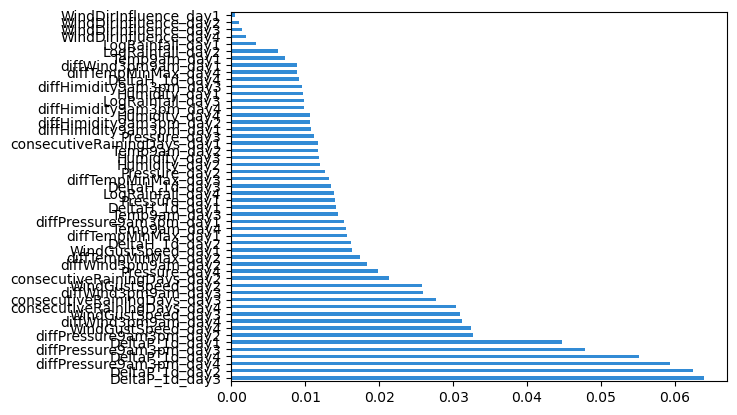

In [242]:
plots = interpreter.feature_importance.plot_feature_importance(skater_model, ascending=True)

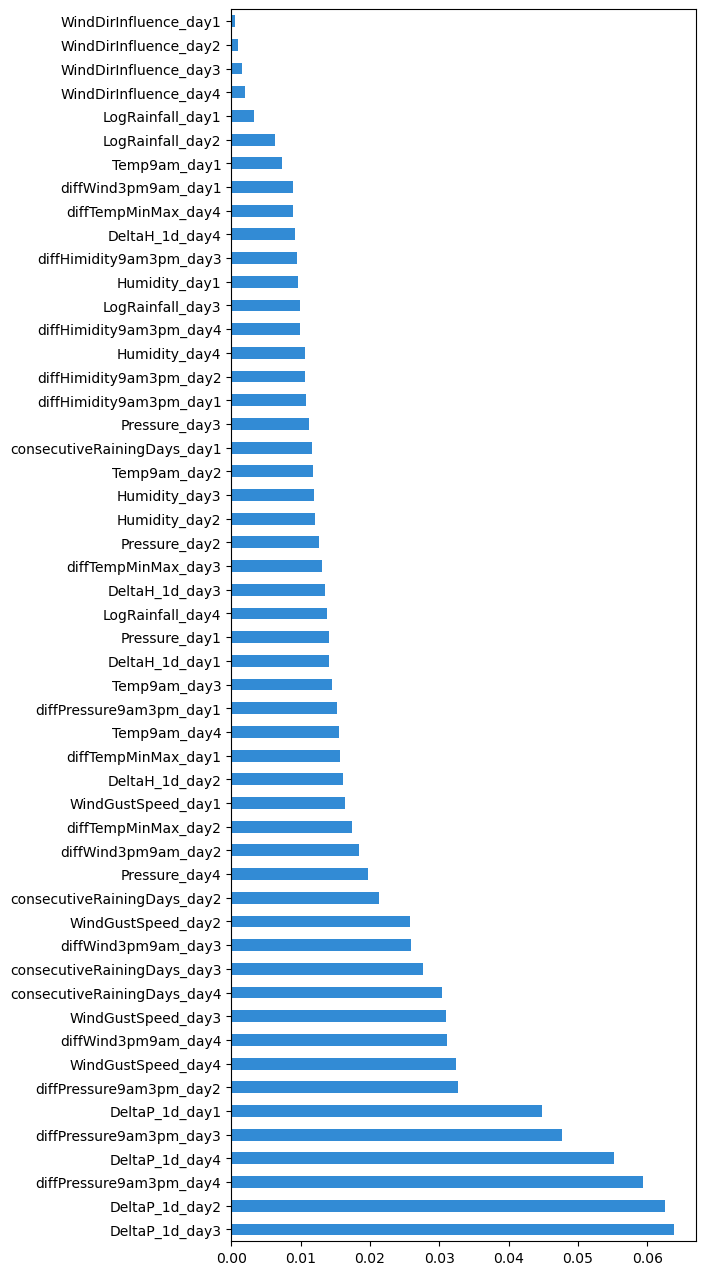

In [243]:
figure_feature_importance = plots[0]
figure_feature_importance.set_size_inches(6, 16)
figure_feature_importance

<h3>Dépendance partielle</h3>

[9/9] grid cells ████████████████████ Time elapsed: 2 secondsds

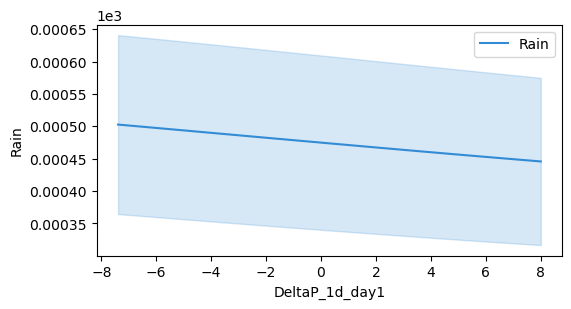

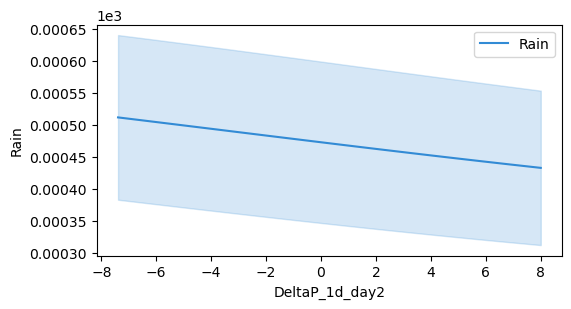

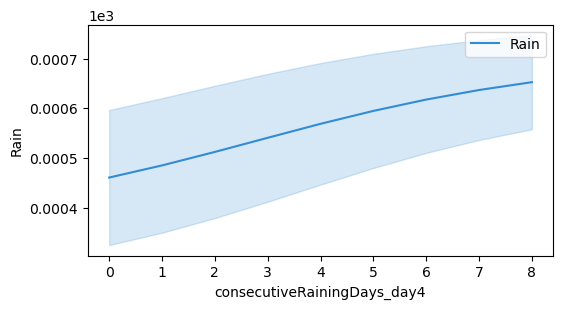

In [244]:
interpreter.partial_dependence.plot_partial_dependence(['DeltaP_1d_day1', 'DeltaP_1d_day2',
                                                       'consecutiveRainingDays_day4'
                                                       ],
                                                       skater_model, grid_resolution=30, with_variance=True, figsize=(6, 3));

<h2>Interprétation locale avec LIME</h2>

In [14]:
exp = LimeTabularExplainer(X_unrolled.to_numpy(), mode='classification', training_labels=y_unrolled,
                           discretize_continuous=True,
                           feature_names = feature_names, class_names=['NoRain', 'Rain']
                          )

In [15]:
def predict_lime(x):
    x = pd.DataFrame(data=x, columns=X_unrolled.columns)
    for i in range(window_size):
        day_cols_to_scale = [str(col) + '_day' + str(window_size - i) for col in cols_to_scale]
        col_name_mapper = {str(col) + '_day' + str(window_size - i):col for col in cols_to_scale}
        xp = x.loc[:, day_cols_to_scale].rename(columns=col_name_mapper)
        xp = scaler.transform(xp)
        x.loc[:, day_cols_to_scale] = xp
    
    xd = np.reshape(x.to_numpy(), (-1, window_size, feature_count))
    y_pred_rainfall = model.predict(xd, batch_size=128)
    y_pred_rainfall = y_pred_rainfall.ravel()
    y_pred_rainfall = np.stack((1.0 - y_pred_rainfall, y_pred_rainfall), axis=-1)
    return y_pred_rainfall


In [16]:
day = 14
expl = exp.explain_instance(X_unrolled.iloc[day,:], predict_lime, num_features=10)
display(expl.as_list())
expl.show_in_notebook()

[('consecutiveRainingDays_day4 <= -0.00', -0.05332551490112419),
 ('diffPressure9am3pm_day4 <= -1743.80', 0.04661514855963094),
 ('DeltaP_1d_day2 <= -2.80', 0.04505854802041047),
 ('DeltaP_1d_day3 <= -2.80', 0.043731093533135874),
 ('consecutiveRainingDays_day3 <= -0.00', -0.04348825402745513),
 ('DeltaP_1d_day4 > 2.70', -0.04188593734467437),
 ('diffPressure9am3pm_day3 <= -1743.76', 0.03663716714267676),
 ('consecutiveRainingDays_day2 <= -0.00', -0.030995560512234777),
 ('DeltaP_1d_day1 <= -2.80', 0.029062543710364184),
 ('diffPressure9am3pm_day2 <= -1743.76', 0.022613223928269373)]

In [17]:
day = 100
expl = exp.explain_instance(X_unrolled.iloc[day,:], predict_lime)
display(expl.as_list())
expl.show_in_notebook()

[('consecutiveRainingDays_day4 <= -0.00', -0.053379433540791006),
 ('consecutiveRainingDays_day3 > -0.00', 0.04621704610082367),
 ('diffPressure9am3pm_day4 > -1726.63', -0.044367658166637604),
 ('diffPressure9am3pm_day3 > -1726.63', -0.037224954941962825),
 ('DeltaP_1d_day1 > 2.70', -0.03434393573826586),
 ('consecutiveRainingDays_day2 <= -0.00', -0.032513866574834835),
 ('WindGustSpeed_day3 > 41.00', -0.02681664810908963),
 ('diffPressure9am3pm_day2 > -1726.63', -0.02290945159611573),
 ('diffWind3pm9am_day4 > 10.33', -0.019706715166252282),
 ('diffWind3pm9am_day3 > 10.33', -0.018570663701434627)]

In [21]:
y_pred = predict_lime(X_unrolled)

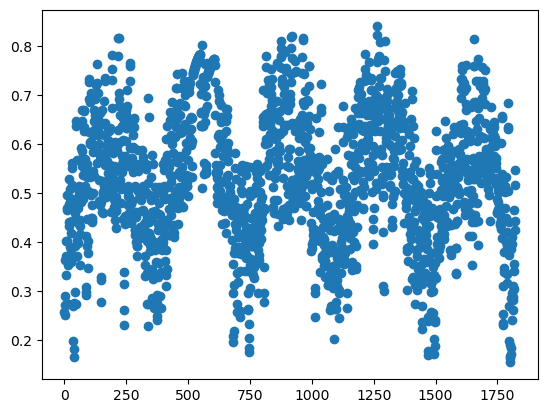

In [23]:
plt.scatter(np.arange(y_pred.shape[0]), y_pred[:,0]);